# DVA Notebook
### by Raffaele Pastore (CNR-SPIN, Napoli) and Marco Caggioni (P&G, Cincinnati)

This notebook is similar to the one used in Ref [1].
It is aimed at applying DVA to digital videos of soft matter sample at equilibrium or in steady state conditions.

If not indicated otherwise, symbols and nomenclature are as in Ref [1].

A sample video can be downloaded at... 
Filename and required parameters are adjusted to fit the sample video features. Change them appropriately if you are using a different video.


We are currently managing to upload a step-by-step tutorial notebook asap.

If DVA or this DVA notebook contributes to a scientific publication, please acknowledge this fact by citing Ref[1] 

#### [1] R. Pastore, G. Pesce and M. Caggioni, Differential Variance Analysis: a direct method to quantify and visualize dynamic heterogeneities, Sci. Rep. (2017). 




In [1]:
#import required libraries
%matplotlib inline
from math import pi
import numpy
import matplotlib
from matplotlib import pylab, mlab, pyplot
np = numpy
plt = pyplot
from matplotlib.pyplot import *
import os
import glob

from IPython.display import display
from IPython.core.pylabtools import figsize, getfigs

from pylab import *
from numpy import *

import pandas as pd

from ipywidgets.widgets import interact, interactive, fixed
from ipywidgets import widgets
from scipy import fftpack
from IPython.display import display
from PIL import Image
import pims
import scipy.optimize as optimization
import pandas as pd
import pymongo

import trackpy
import warnings
warnings.filterwarnings("ignore")

## General video requirements
Let us indicate with $\tau_{br}$ an estimation, even broad, of the structural relaxation time of the imaged sample, with $t_v$ the overall video duration and with $t_f$ the time interval between subsequent frames ($t_f=fps^{-1}$).  

Your video should comply with the following reuirements for DVA to be fully applicable:

1) $t_v>\tau_{br}$   (e.g. $t_v=10\tau_{br}$ or larger)

2) $t_f\ll \tau_{br}$ (e.g. $t_f=0.01\tau_{br}$ or smaller)



In [2]:
# define video object

filename='vacq00_vf071/*.tif' #this is the name of the sample video. 
#Change it with the appropriate filename, if you are using a different video

video=trackpy.ImageSequence(filename)
info={'interval': 0.5, #interval between frames in sec
      'muperpix': 0.152, #spacial calibration of the image micron per pixel
      'filename': filename,
      'phi':0.71
     }
video.info=info
#video.frame_shape[0]
#len(video)

## Preliminary estimation of the relaxation time

To check wheter your video complies with the above criteria and proceed with full DVA, you should know a broad estimation of your system structural relaxation time, at least as order of magnitude. 
You may already have an idea about this, for example from a previous experiment. If this is not the case, you can use DVA to have a  preliminary estimation of the relaxation time. The simplest way to do this consists in calculating the non-averaged differential variance $\hat V(0, $\Delta t$)$, as in the cell below. Then, you can get $\tau_{br}$ as the time where the variance rougly attains $2/3$ of its plateau value.

In [3]:
def get_nonaveraged_var(video):
    total_frames=len(video)-1
    delta_list=list(range(1,total_frames,10)) #list of lag-times
    temp_frame=[]
    list_single_var=[]
    
    for delta in delta_list:
        im1=video[0].astype(np.float)
        im2=video[delta].astype(np.float)
        im_diff=im2-im1
               
        list_single_var.append(var(im_diff))
    
    result_tau=pd.DataFrame({'delta':delta_list,'variance':list_single_var}) 
    return result_tau
    

In [4]:
result_tau=get_nonaveraged_var(video)

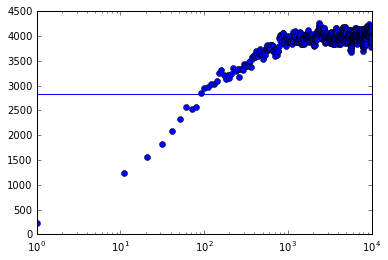

In [6]:
plot(result_tau.delta,result_tau.variance,'o')
axhline(4250*2/3) #\simeq 2/3*plateau_value
xscale('log')


If your variance does not attain a plateu, your video is probably too short ($t_v$ is smaller or similar to $\tau_{br}$). If your variance is flat, the acquisition rate is probably too large ($t_v \simeq \tau_{br}$ or larger). Otherwise, fix the value of $\tau_{br}$ and go ahead.

In [7]:
#rough estimation of relaxation time, V(tau_br)/plateau_value=2/3
global tau_br
tau_br=100 # [frames] 

## Differential Variance Analysis

In [9]:
#definition of get_DVA

def get_DVA(video):
    '''Input: video object
       Output: Dataframe col1 - Dt, col2 - sigma intensity
       Exmple: sigma_intensity=get_sigma_intensity(video,deltalist)
    '''

#variables
    phi=video.info['phi'] #volume fraction
    L=video.frame_shape[0]*video.info['muperpix']#microns    system size
    A=L*L #microns^2  = field of view  
    As=pi*((2.31/2)**2.0) # microns^2= small particle area
    Al=pi*((3.16/2)**2.0) # microns^2= small particle area
    N=phi*2*A/(As+Al) #estimation of the total number in the field of view
    print('N=' + str(N))

    ########## ADJUSTING PARAMETERS #################
    total_frames=len(video)-1
       
    delta_max=50*tau_br # should be larger than tau_br, but smaller than total_frames
    
    global n_average
    n_average=100
    
           
    global delta_step
    delta_step=1 #[frames] desired step between lag-time (much smaller than tau_br)
    asympt_var=0 # this corresponds to V_{\infty}    
    t_asympt=100 # number of last frames to estimate V_{\infty}
    #####################################
    
    
    mean_var=[] # Average variance
    mean_square_var=[] #Average of the square variance ""
    square_mean_var=[] # square of the average variance ""    
    delta_list=list(range(1,delta_max,delta_step)) #list of lag-times
    delta_t=[]
    
    print('delta_max=' + str(delta_max))
    print('delta_step=' + str(delta_step))

#AVERAGING PROTOCOL: Besides that reported below, other averaging protocols
#can be fully appropriate and provide similar results.
    for delta in delta_list:
        iframe_step=int(1+(total_frames-delta)/n_average) 
#delay between replicas. This parameter is used in averaging.
#As far as iframe_step>tau_br, one is considering fully uncorrelated replicas. 
#However, this is not always possible due to large tau_br and limited video duration (your video barely complies with reqirement 1), 
#and one should include correlated replicas.        
        delta_t.append(delta*video.info['interval'])
        temp_frame=[]
        
        for frame in range(0,total_frames-delta,iframe_step): 
            im1=video[frame].astype(np.float)
            im2=video[frame+delta].astype(np.float)
            im_diff=im2-im1

            temp_frame.append(im_diff)
        
        list_single_var=list(map(var,temp_frame))
        
        mean_var.append(mean(list_single_var))
        
        square_mean_var.append(mean(list_single_var)**2.0)
        mean_square_var.append(mean(list(map(square,list_single_var))))
    
    asympt_var=mean(mean_var[-t_asympt:]) #estimation of the platea value V_{\infty}
    print('asympt_var=' + str(asympt_var))
    
    result=pd.DataFrame({'delta':delta_list,'delta_t':delta_t,'mean_var':mean_var,
                         'square_mean_var':square_mean_var,'mean_square_var':mean_square_var})
    
    result['dop']=(1-result.mean_var/asympt_var) #dynamic order parameter
    result['chi_4']=(N*(result.mean_square_var-result.square_mean_var)/(asympt_var*asympt_var)) # dynamic susceptibility
    
    return result

In [ ]:
result=get_DVA(video)

N=628.1468107346243
delta_max=5000
delta_step=1


In [ ]:
#This cell allows to save the results in a csv file
result.to_csv('your_data_folder/your_datafile.dat',sep='\t',header=False)

### Average Differential Variance, $V(t)$

In [ ]:
plot(result.delta_t,result.mean_var,'o')
xscale('log')
xlabel('$\Delta t$ [s]', fontsize=20)
ylabel('$V$', fontsize=20)
xlim(0.1,3000)

### Dynamic Order Parameter, $Q(t)$

In [ ]:
plot(result.delta_t,result.dop,'o')
xscale('log')
xlabel('$\Delta t$ [s]', fontsize=20)
ylabel('$Q$', fontsize=20)

### Relaxation time, $\tau$
$Q(\tau)=1/e$

In [ ]:
tau=max(result.delta_t[result.dop>1/math.e]) 
tau #[s]

### Dynamic Susceptibility, $\chi_4(t)$

In [ ]:
plot(result.delta_t,result.chi_4, '.',label=str(video.info['phi']))
legend()
xlabel('t [s]', fontsize=20)
ylabel('$\chi_{4}$', fontsize=20)
xscale('log')

#Dynamic susceptibility data are usually shown using logarithimic time.
#You may perform a running average over logarithmically scaled times and get a smoother curve.

### Maximum value, $\chi*$, and time, $t*$, of the dynamic susceptibility

In [ ]:
chi4_max=max(result.chi_4) 

t_max=max(result.delta_t[result.chi_4==chi4_max]) 


In [ ]:
chi4_max 

In [ ]:
t_max # [s]

In [ ]:
#show results
result